In [1]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

# For iSOM Data Generation
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# --- Installation Note ---
# !pip install minisom sklearn pandas seaborn matplotlib

print("Setup Complete!")

Setup Complete!


In [2]:
# ===================================================================
# Cell 2: Helper Functions (from our previous notebooks)
# ===================================================================

def generate_isom_data(df_real, target_column, num_synthetic):
    if num_synthetic <= 0:
        return pd.DataFrame(columns=df_real.columns)
    
    print(f"Generating {num_synthetic} synthetic samples from a base of {len(df_real)} real samples...")
    
    X_real = df_real.drop(columns=[target_column]).values
    y_real = df_real[target_column].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_real)

    map_size = int(np.sqrt(5 * np.sqrt(X_scaled.shape[0])))
    som_grid_size = (map_size, map_size)
    
    som = MiniSom(som_grid_size[0], som_grid_size[1], X_scaled.shape[1],
                  sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(X_scaled)
    som.train_random(X_scaled, 500)

    def get_neighbors(x, y, grid_size):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1]:
                neighbors.append((nx, ny))
        return neighbors

    weights = som.get_weights()
    synthetic_samples = []
    rng = np.random.default_rng(42)

    for _ in range(num_synthetic):
        x1, y1 = rng.integers(som_grid_size[0]), rng.integers(som_grid_size[1])
        valid_neighbors = get_neighbors(x1, y1, som_grid_size)
        if not valid_neighbors: continue
        x2, y2 = rng.choice(valid_neighbors)
        node1_weights, node2_weights = weights[x1, y1], weights[x2, y2]
        alpha = rng.random()
        new_sample_scaled = alpha * node1_weights + (1 - alpha) * node2_weights
        distances = np.linalg.norm(X_scaled - new_sample_scaled, axis=1)
        new_target = y_real[np.argmin(distances)]
        synthetic_samples.append(np.append(new_sample_scaled, new_target))

    synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
    synthetic_features_scaled = synthetic_df.drop(columns=[target_column]).values
    synthetic_features_orig = scaler.inverse_transform(synthetic_features_scaled)
    synthetic_df[df_real.drop(columns=[target_column]).columns] = synthetic_features_orig
    synthetic_df[target_column] = synthetic_df[target_column].astype(int)
    return synthetic_df

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path):
    _, dataset_name = os.path.split(base_path)
    with open(os.path.join(base_path, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, f"{dataset_name}.{meta['format']}"))
    return train_data, meta

print("Helper functions defined.")

Helper functions defined.


In [3]:
# ===================================================================
# Cell 3: Configuration & Data Loading
# ===================================================================

# --- Parameters ---
DATASET_NAME = "airfoil_cl_m"
BASE_DATA_PATH = "data"
REAL_DATA_FRACTION = 0.2 # The small fraction of real data to use as a base for generation

# --- Load and Prepare Data ---
dataset_path = os.path.join(BASE_DATA_PATH, DATASET_NAME)
df_real, meta = load_data(dataset_path)
y_column = meta["label"]

# # Handle potential regression target
# if pd.api.types.is_float_dtype(df_real[y_column]):
#     print("Continuous target detected. Converting to binary classes using the median as a threshold.")
#     threshold = df_real[y_column].median()
#     df_real[y_column] = (df_real[y_column] <= threshold).astype(int)

# Create the subset of real data and generate synthetic data from it
df_real_subset = df_real.sample(frac=REAL_DATA_FRACTION, random_state=42)
df_synthetic = generate_isom_data(df_real_subset, y_column, num_synthetic=len(df_real))

print(f"\nReal data shape: {df_real.shape}")
print(f"Synthetic data shape: {df_synthetic.shape}")

Generating 1108 synthetic samples from a base of 222 real samples...

Real data shape: (1108, 101)
Synthetic data shape: (1108, 101)


In [4]:
# ===================================================================
# Cell 4: Analysis 1 - Viewing the Tables and Basic Info
# ===================================================================
# The simplest check is to just look at the data.

print("--- First 5 rows of REAL data ---")
display(df_real.head())

print("\n--- First 5 rows of SYNTHETIC data ---")
display(df_synthetic.head())

print("\n--- Data types and info for REAL data ---")
df_real.info()

print("\n--- Data types and info for SYNTHETIC data ---")
df_synthetic.info()

--- First 5 rows of REAL data ---


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y45,x46,y46,x47,y47,x48,y48,x49,y49,good_cl_m
0,1.000007,0.001541,0.955249,0.011313,0.910469,0.020797,0.865661,0.029975,0.820820,0.038828,...,0.018410,0.863774,0.013923,0.909196,0.009088,0.954609,0.003898,1.000025,-1.651906e-03,1
1,1.000004,0.006163,0.957184,0.016478,0.913997,0.025807,0.870483,0.034259,0.826681,0.041944,...,0.013279,0.865877,0.010456,0.910705,0.007359,0.955415,0.003899,1.000000,-5.812635e-08,2
2,1.000004,0.003030,0.957552,0.012771,0.914612,0.021335,0.871220,0.028944,0.827416,0.035825,...,0.007394,0.865780,0.005318,0.910362,0.002776,0.955098,-0.000094,0.999994,-3.136940e-03,2
3,0.999997,0.006819,0.956759,0.008339,0.913190,0.011023,0.869257,0.014538,0.824926,0.018529,...,-0.010361,0.866185,-0.007747,0.910861,-0.005206,0.955490,-0.002643,0.999999,4.001275e-05,2
4,1.000006,0.000752,0.955605,0.005170,0.911222,0.009573,0.866869,0.013927,0.822543,0.018201,...,-0.003134,0.866129,-0.002485,0.910754,-0.001839,0.955377,-0.001198,0.999997,-5.619498e-04,2



--- First 5 rows of SYNTHETIC data ---


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y45,x46,y46,x47,y47,x48,y48,x49,y49,good_cl_m
0,1.000015,-0.000414,0.958713,0.008911,0.915278,0.017230,0.871440,0.024690,0.827324,0.031396,...,-0.006502,0.876035,-0.002347,0.919011,-0.000099,0.961124,-0.000149,1.000013,-0.002930,2
1,1.000015,0.003049,0.960806,0.011563,0.917650,0.019671,0.873507,0.027407,0.829203,0.034973,...,-0.001661,0.871178,-0.001469,0.916018,-0.001135,0.959771,-0.000438,1.000014,0.000769,2
2,0.999990,0.000878,0.956754,0.008191,0.912847,0.015891,0.868685,0.023623,0.824493,0.031209,...,-0.009965,0.868379,-0.007047,0.912717,-0.004452,0.956735,-0.002342,1.000007,-0.000758,2
3,1.000010,-0.000162,0.956561,0.010085,0.912609,0.020232,0.868595,0.030407,0.824583,0.040671,...,-0.007599,0.867831,-0.004667,0.912060,-0.002301,0.955931,-0.000944,1.000004,-0.000452,2
4,1.000003,0.000311,0.957262,0.010050,0.913787,0.018973,0.869800,0.027367,0.825660,0.035325,...,0.007095,0.865884,0.005413,0.910824,0.003533,0.955622,0.001581,0.999999,-0.000181,2



--- Data types and info for REAL data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Columns: 101 entries, x0 to good_cl_m
dtypes: float64(100), int64(1)
memory usage: 874.4 KB

--- Data types and info for SYNTHETIC data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Columns: 101 entries, x0 to good_cl_m
dtypes: float64(100), int32(1)
memory usage: 870.1 KB


In [5]:
# ===================================================================
# Cell 5: Analysis 2 - Statistical Comparison
# ===================================================================
# Let's compare the basic statistics (mean, std, quartiles) of the two datasets.
# A good synthetic dataset should have similar statistics to the real one.

print("--- Descriptive Statistics for REAL data ---")
display(df_real.describe())

print("\n--- Descriptive Statistics for SYNTHETIC data ---")
display(df_synthetic.describe())

--- Descriptive Statistics for REAL data ---


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y45,x46,y46,x47,y47,x48,y48,x49,y49,good_cl_m
count,1108.000000,1.108000e+03,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,...,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,1.000012,9.199171e-04,0.958429,0.009902,0.914991,0.018792,0.871029,0.027478,0.826929,0.036041,...,-0.006827,0.868755,-0.004783,0.913317,-0.003077,0.957421,-0.001792,0.999837,-0.000898,1.768051
std,0.008278,5.009455e-03,0.009720,0.006956,0.010653,0.009951,0.011011,0.013100,0.011490,0.015878,...,0.016096,0.013875,0.013290,0.013662,0.010005,0.013273,0.006687,0.012560,0.004956,0.860342
min,0.811698,-8.993728e-02,0.780482,-0.062797,0.748872,-0.039588,0.718278,-0.020153,0.688267,-0.004849,...,-0.209270,0.538848,-0.194940,0.571350,-0.149248,0.602948,-0.096509,0.633609,-0.089939,0.000000
25%,0.999997,1.467159e-07,0.955795,0.005908,0.911487,0.012286,0.867131,0.018490,0.822783,0.025056,...,-0.016398,0.864972,-0.012247,0.910080,-0.008336,0.955058,-0.004803,0.999998,-0.001000,1.000000
50%,1.000001,1.117480e-04,0.956541,0.009745,0.912784,0.018293,0.868869,0.026734,0.824713,0.034949,...,-0.006669,0.866871,-0.004504,0.911351,-0.003047,0.955775,-0.001678,1.000000,-0.000059,2.000000
75%,1.000012,1.312934e-03,0.958417,0.012686,0.915307,0.023773,0.871599,0.034252,0.827898,0.044831,...,0.002322,0.870414,0.002589,0.914455,0.002403,0.958006,0.001316,1.000007,0.000006,2.000000
max,1.200030,6.032968e-02,1.154485,0.094031,1.109849,0.141839,1.062505,0.192437,1.012904,0.218562,...,0.047873,1.050703,0.039239,1.100475,0.029967,1.149451,0.035432,1.200010,0.039500,3.000000



--- Descriptive Statistics for SYNTHETIC data ---


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y45,x46,y46,x47,y47,x48,y48,x49,y49,good_cl_m
count,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,...,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,1.000121,0.000793,0.959392,0.010149,0.916196,0.019511,0.872242,0.028637,0.828019,0.037570,...,-0.008366,0.869180,-0.005847,0.913853,-0.003643,0.957981,-0.001870,1.000120,-0.000583,1.988267
std,0.000565,0.000663,0.005217,0.003022,0.006528,0.005525,0.006988,0.007769,0.007155,0.009862,...,0.009935,0.005732,0.007548,0.005355,0.005145,0.004222,0.002712,0.000565,0.000834,0.725611
min,0.999983,-0.000692,0.955774,0.003593,0.911285,0.007846,0.866886,0.012283,0.822353,0.016294,...,-0.031583,0.863075,-0.023122,0.908958,-0.014978,0.954764,-0.009081,0.999983,-0.005357,0.000000
25%,1.000002,0.000307,0.956748,0.008187,0.912827,0.016071,0.868595,0.023882,0.824293,0.031332,...,-0.014426,0.865847,-0.010429,0.910958,-0.006820,0.955789,-0.003599,1.000002,-0.000801,2.000000
50%,1.000006,0.000706,0.957540,0.010118,0.913866,0.019474,0.869716,0.028626,0.825392,0.037517,...,-0.008328,0.867620,-0.006017,0.912177,-0.003720,0.956524,-0.001746,1.000005,-0.000512,2.000000
75%,1.000018,0.001130,0.959668,0.012210,0.916487,0.023211,0.872350,0.033894,0.828126,0.043943,...,-0.001471,0.869740,-0.000779,0.914151,-0.000275,0.957909,-0.000090,1.000012,-0.000213,2.000000
max,1.005597,0.003544,0.986727,0.022262,0.949288,0.039436,0.906631,0.054644,0.862318,0.068544,...,0.022158,0.900019,0.018347,0.943585,0.013102,0.981696,0.006503,1.005596,0.002872,3.000000


--- Comparing Feature Distributions (Real vs. Synthetic) ---


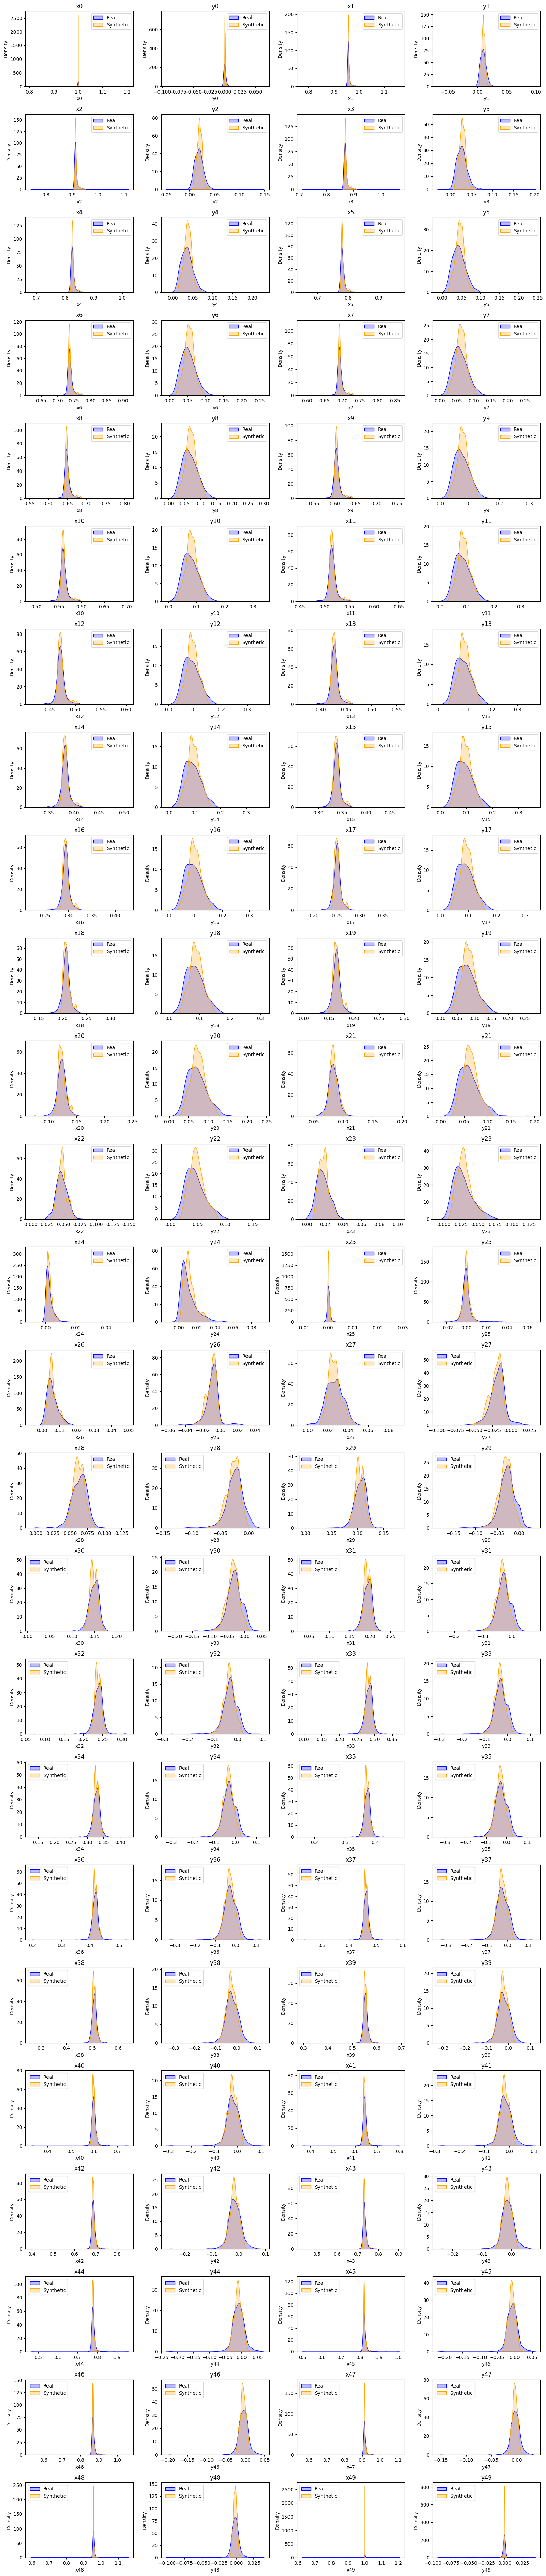

In [6]:
# ===================================================================
# Cell 6: Analysis 3 - Distribution Plots (KDE)
# ===================================================================
# This is a key visual check. We plot the distribution of each feature for
# both datasets. If the synthetic data is good, its distribution (orange)
# should closely match the real data's distribution (blue).

print("--- Comparing Feature Distributions (Real vs. Synthetic) ---")
features = df_real.drop(columns=[y_column]).columns
num_features = len(features)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 3))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.kdeplot(df_real[feature], ax=axes[i], label="Real", color="blue", fill=True)
    sns.kdeplot(df_synthetic[feature], ax=axes[i], label="Synthetic", color="orange", fill=True)
    axes[i].set_title(feature)
    axes[i].legend()

# Hide any unused subplots
for i in range(num_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

--- Comparing Correlation Structures ---


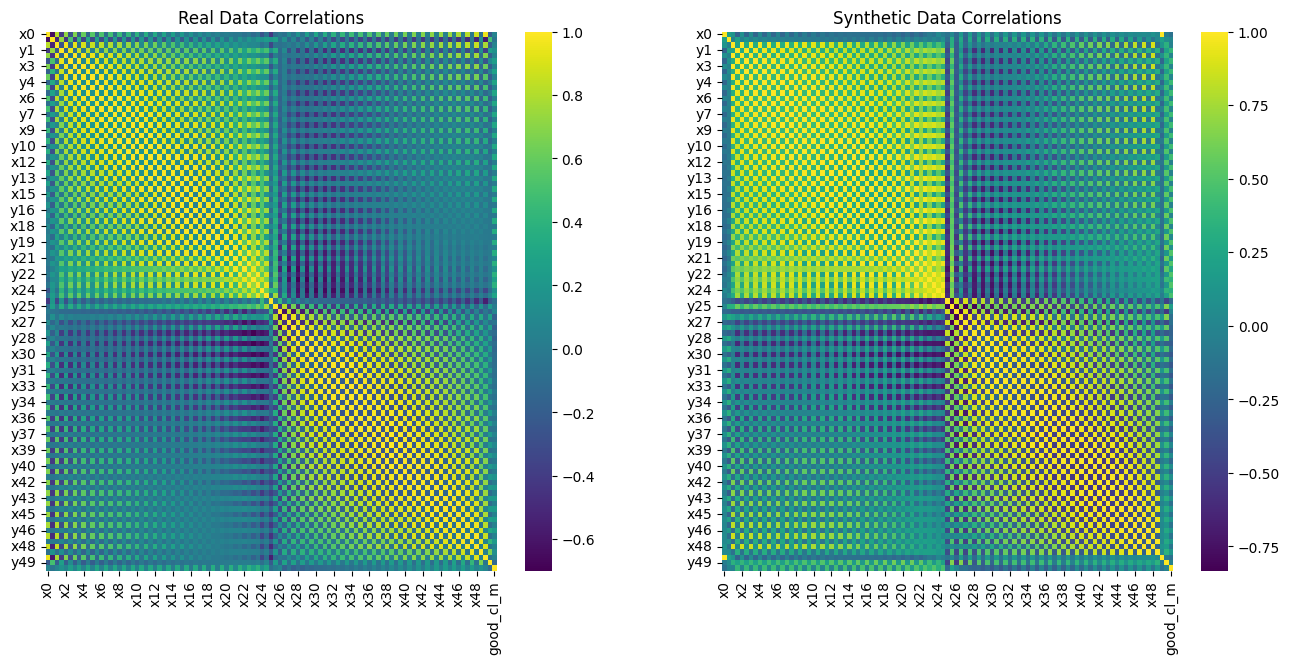

In [7]:
# ===================================================================
# Cell 7: Analysis 4 - Correlation Heatmaps
# ===================================================================
# A good synthetic dataset should preserve the relationships (correlations)
# between features. We can visualize this with heatmaps.

print("--- Comparing Correlation Structures ---")
corr_real = df_real.corr()
corr_synthetic = df_synthetic.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_real, ax=ax1, cmap="viridis").set_title("Real Data Correlations")
sns.heatmap(corr_synthetic, ax=ax2, cmap="viridis").set_title("Synthetic Data Correlations")

plt.show()

--- Visualizing Data Diversity with PCA ---


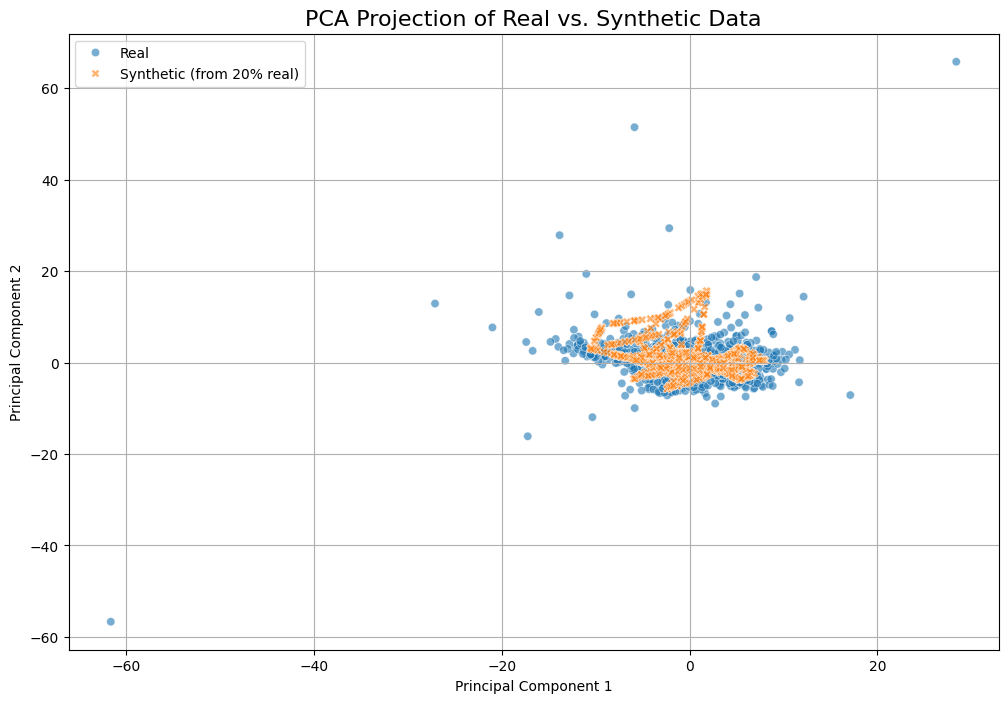

In [8]:
# ===================================================================
# Cell 8: Analysis 5 - PCA for Diversity Visualization
# ===================================================================
# This is the most powerful visualization to check for diversity. We use PCA to
# project the high-dimensional data into 2D. This allows us to see the "shape"
# and "spread" (extent and uniformity) of the data.

print("--- Visualizing Data Diversity with PCA ---")

# Prepare data for PCA
X_real_features = df_real.drop(columns=[y_column])
X_synthetic_features = df_synthetic.drop(columns=[y_column])

# Scale the data before applying PCA
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real_features)
X_synthetic_scaled = scaler.transform(X_synthetic_features) # Use the same scaler

# Apply PCA
pca = PCA(n_components=2)
X_real_pca = pca.fit_transform(X_real_scaled)
X_synthetic_pca = pca.transform(X_synthetic_scaled)

# Create a DataFrame for plotting
df_pca_real = pd.DataFrame(X_real_pca, columns=["PC1", "PC2"])
df_pca_real['source'] = 'Real'

df_pca_synthetic = pd.DataFrame(X_synthetic_pca, columns=["PC1", "PC2"])
df_pca_synthetic['source'] = 'Synthetic (from 20% real)'

df_pca = pd.concat([df_pca_real, df_pca_synthetic])

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='source', style='source', alpha=0.6)
plt.title("PCA Projection of Real vs. Synthetic Data", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()